In [ ]:
%load core.py

/home/lachlan/.pyenv/versions/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


script: /home/lachlan/CODEBASE/ReadoutXFM/config.py
script path: /home/lachlan/CODEBASE/ReadoutXFM
data path: /home/lachlan/CODEBASE/ReadoutXFM/data
---------------
opening .geo: geo2
---------------------------
EXTRACTING SPECTRA
---------------------------
filesize: 195154338 (bytes)
header length: 1492 (bytes)
map dimensions: 256 x 126
pixels expected: 32256
---------------------------
saving spectrum-by-pixel to file 193333742 (99.1 %)
---------------------------
MAP COMPLETE
---------------------------
pixels expected (X*Y): 32256
pixels found: 32256
total time: 94.16 s
time per pixel: 0.002919 s
---------------------------
                          data: 252.0 MiB
                     corrected: 252.0 MiB
                        stream: 186.1 MiB
                         rvals: 252.1 KiB
                         gvals: 252.1 KiB
                         bvals: 252.1 KiB
                   totalcounts: 252.1 KiB
                         pxlen: 63.1 KiB
                          xi

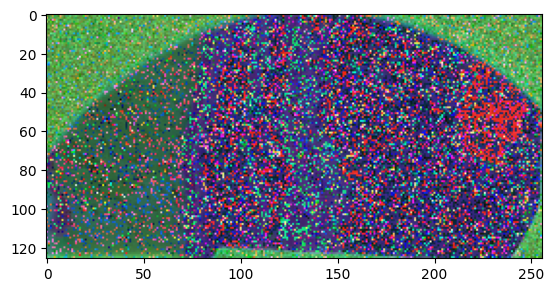

DOCLUST True
REDUCER 1 of 2: PCA across 32256 elements
REDUCER 2 of 2: UMAP across 32256 elements
KMEANS clustering 1 of 2, reducer PCA across 32256 elements
running: PCA
complete: PCA
KMEANS clustering 2 of 2, reducer UMAP across 32256 elements
running: UMAP
complete: UMAP
saving reducer PCA cluster 0 with shape (4096,)
saving reducer PCA cluster 1 with shape (4096,)
saving reducer PCA cluster 2 with shape (4096,)
saving reducer PCA cluster 3 with shape (4096,)
saving reducer PCA cluster 4 with shape (4096,)
saving reducer PCA cluster 5 with shape (4096,)
saving reducer PCA cluster 6 with shape (4096,)
saving reducer PCA cluster 7 with shape (4096,)
saving reducer PCA cluster 8 with shape (4096,)
saving reducer PCA cluster 9 with shape (4096,)
saving combined file for PCA
saving reducer UMAP cluster 0 with shape (4096,)
saving reducer UMAP cluster 1 with shape (4096,)
saving reducer UMAP cluster 2 with shape (4096,)
saving reducer UMAP cluster 3 with shape (4096,)
saving reducer UMAP 

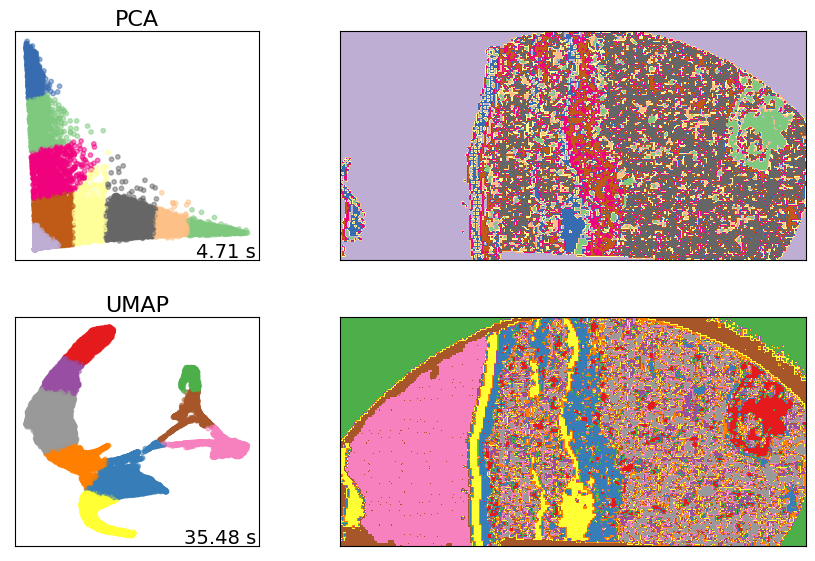

CLEAN EXIT


'\nsnip background\nhttps://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data\n'

In [1]:
# %load core.py
import os
import time
import gc
import time
import json

import numpy as np
from sklearn import decomposition
import umap.umap_ as umap

import config
import src.utils as utils
import src.bitops as bitops
import src.colour as colour
import src.clustering as clustering
import src.fitting as fitting
"""
Parses spectrum-by-pixel maps from IXRF XFM

- parses binary .GeoPIXE files
- extracts pixel parameters
- projects spectra onto simple RGB channels
- displays as RGB

./data has example dataset

SPEED
                t/px
reading only:   0.00014 
colourmap:      0.0078
read and clust  0.001296 

"""

#-----------------------------------
#CLASSES
#-----------------------------------

#-----------------------------------
#INITIALISE
#-----------------------------------

starttime = time.time()             #init timer
chan=np.arange(0,config.NCHAN)      #channels
energy=chan*config.ESTEP            #energy list
noisecorrect=True                   #apply adjustment to SNIP to fit noisy pixels

#if we are creating colourmaps, set up colour routine
if config.DOCOLOURS == True: colour.initialise(energy)

#-----------------------------------
#MAIN START
#-----------------------------------

#check filetype is recognised - currently only accepts .GeoPIXE
if config.FTYPE == ".GeoPIXE":
    f = os.path.join(config.wdir,config.infile)
    fname = os.path.splitext(os.path.basename(f))[0]

    print("opening .geo:",fname)
else: 
    print(f'FATAL: filetype {config.FTYPE} not recognised')
    exit()

print(
    "---------------------------\n"
    "EXTRACTING SPECTRA\n"
    "---------------------------"
)

#open the datafile 
with open(f, mode='rb') as file: # rb = read binary
    
    #generate bytestream
    stream = file.read()         #NB. to read in chunks, add chunk size as read(SIZE)
    streamlen=len(stream)

    print(f"filesize: {streamlen} (bytes)")

    headerlen=bitops.binunpack(stream,0,"<H")[0]

    #check for header
    #   pixels start with "DP" (=20550 as <uint16)
    #   if we find this immediately, header is zero length
    #provided header is present
    #   read params from header
    if headerlen == 20550:
        print("WARNING: no header found")
        headerlen=0
        mapx=config.MAPX
        mapy=config.MAPY
        print("WARNING: map dimensions not found")
        print(f"-------using defaults {mapx},{mapy}")
    else:
        """
        if header present, read as json
        https://stackoverflow.com/questions/40059654/python-convert-a-bytes-array-into-json-format
        """
        #pull slice of byte stream corresponding to header
        #   bytes[0-2]= headerlen
        #   headerlen doesn't include trailing '\n' '}', so +2
        headerstream=stream[2:headerlen+2]
        #read it as utf8
        headerstream = headerstream.decode('utf8')
        
        #load into dictionary via json builtin
        headerdict = json.loads(headerstream)

        #create a human-readable dump for debugging
        headerdump = json.dumps(headerdict, indent=4, sort_keys=False)
        
        #get params
        mapx=headerdict['File Header']['Xres']  #map dimension x
        mapy=headerdict['File Header']['Yres']  #map dimension y

    #assign map size based on dimensions
    totalpx=mapx*mapy     

    #print run params
    print(f"header length: {headerlen} (bytes)")
    print(f"map dimensions: {mapx} x {mapy}")

    #   if we are skipping some of the file
    #       assign the ratio and adjust totalpx
    if config.SHORTRUN:
        skipratio=config.shortpct/100
        trunc_y=int(np.ceil(mapy*skipratio))
        totalpx=mapx*trunc_y
        print(f"SHORT RUN: ending at {skipratio*100} %")

    print(f"pixels expected: {totalpx}")
    print("---------------------------")

    if config.FORCEREAD:
        #assign starting pixel index 
        idx=headerlen+2 #legnth of header + 2 bytes

        #initialise pixel param arrays
        pxlen=np.zeros(totalpx,dtype=np.uint16)
        xidx=np.zeros(totalpx,dtype=np.uint16)
        yidx=np.zeros(totalpx,dtype=np.uint16)
        det=np.zeros(totalpx,dtype=np.uint16)
        dt=np.zeros(totalpx,dtype=np.uint16)
        
        if config.DOCOLOURS == True:
            #initalise pixel colour arrays
            rvals=np.zeros(totalpx)
            gvals=np.zeros(totalpx)
            bvals=np.zeros(totalpx)
            totalcounts=np.zeros(totalpx)

        #initialise data array
        data=np.zeros((totalpx,config.NCHAN),dtype=np.uint16)
        if config.DOBG: corrected=np.zeros((totalpx,config.NCHAN),dtype=np.uint16)

        i=0 #pixel counter
        j=0 #row counter

        #loop through pixels
        while idx < streamlen:

            #print pixel index every row px
            if i % mapx == 0: 
                print(f"Row {j}/{mapy} at pixel {i}, byte {idx} ({100*idx/streamlen:.1f} %)", end='\r')
                j+=1

            #read pixel record into spectrum and header param arrays, 
            # + reassign index at end of read
            outchan, counts, pxlen[i], xidx[i], yidx[i], det[i], dt[i], idx = bitops.readpxrecord(idx, stream)

            #fill gaps in spectrum 
            #   (ie. assign all zero-count chans = 0)
            outchan, counts = utils.gapfill(outchan,counts, config.NCHAN)

            #warn if recieved channel list is different length to chan array
            if len(outchan) != len(chan):
                print("WARNING: unexpected length of channel list")
        
            #assign counts into data array
            data[i,:]=counts

            #if we are attempting to fit a background
            #   apply it, and save the corrected spectra
            if config.DOBG: 
                counts, bg = fitting.fitbaseline(counts, noisecorrect)
                corrected[i,:]=counts

            #build colours if required
            if config.DOCOLOURS == True: rvals[i], bvals[i], gvals[i], totalcounts[i] = colour.spectorgb(energy, counts)
            
            #if pixel index greater than expected no. pixels based on map dimensions
            #   end if we are doing a truncated run
            #   else throw a warning
            if i > (totalpx-1):
                if (config.SHORTRUN == True):   #i > totalpx is expected for short run
                    print("ending at:", idx)
                    idx=streamlen+1
                    break 
                else:
                    print(f"WARNING: pixel count {i} exceeds expected map size {totalpx}")
            i+=1

        nrows=j #store no. rows read successfully

        runtime = time.time() - starttime

        if config.SAVEPXSPEC:
            print(f"saving spectrum-by-pixel to file")
            np.savetxt(os.path.join(config.odir,  config.savename + ".dat"), data, fmt='%i')
        
        np.savetxt(os.path.join(config.odir, "pxlen.txt"), pxlen, fmt='%i')
        np.savetxt(os.path.join(config.odir, "xidx.txt"), xidx, fmt='%i')
        np.savetxt(os.path.join(config.odir, "yidx.txt"), yidx, fmt='%i')
        np.savetxt(os.path.join(config.odir, "detector.txt"), det, fmt='%i')
        np.savetxt(os.path.join(config.odir, "dt.txt"), dt, fmt='%i')


        print(
        "---------------------------\n"
        "MAP COMPLETE\n"
        "---------------------------\n"
        f"pixels expected (X*Y): {totalpx}\n"
        f"pixels found: {i}\n"
        f"total time: {round(runtime,2)} s\n"
        f"time per pixel: {round((runtime/i),6)} s\n"
        "---------------------------"
    )
    else:
        print("loading from file", config.savename)
        data = np.loadtxt(os.path.join(config.odir, config.savename), dtype=np.uint16)
        pxlen=np.loadtxt(os.path.join(config.odir, "pxlen.txt"), dtype=np.uint16)
        xidx=np.loadtxt(os.path.join(config.odir, "xidx.txt"), dtype=np.uint16)
        yidx=np.loadtxt(os.path.join(config.odir, "yidx.txt"), dtype=np.uint16)
        det=np.loadtxt(os.path.join(config.odir, "detector.txt"), dtype=np.uint16)
        dt=np.loadtxt(os.path.join(config.odir, "dt.txt"), dtype=np.uint16)
        print("loaded successfully", config.savename)
    "---------------------------\n"
    "Memory usage:\n"
    "---------------------------\n"
    utils.varsizes(locals().items())

    #clear the bytestream from memory
    del stream
    gc.collect()

    if config.DOCOLOURS == True:
        rgbarray=colour.clcomplete(rvals, gvals, bvals, mapx, nrows)
        colour.clshow(rgbarray)

    print("DOCLUST", config.DOCLUST)
    if config.DOCLUST:
        embedding, clusttimes = clustering.reduce(data)
        categories = clustering.dokmeans(embedding, totalpx)

        clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])

        for i in range(len(clustering.reducers)):
            redname=clustering.getredname(i)
            clustaverages[i]=clustering.sumclusters(data, categories[i])
            
            for j in range(config.nclust):
                print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
                np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
            
            print(f'saving combined file for {redname}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
            #plt.plot(energy, clustaverages[i,j,:])
        clustering.clustplt(embedding, categories, mapx, clusttimes)


print("CLEAN EXIT")


"""
snip background
https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
"""

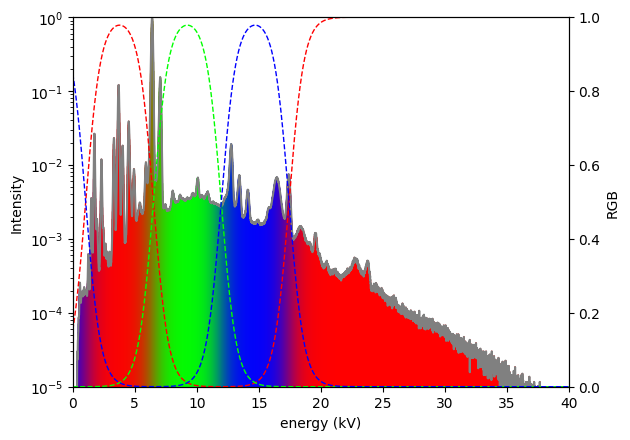

<Figure size 640x480 with 0 Axes>

In [150]:
# from:
# https://stackoverflow.com/questions/11564273/matplotlib-continuous-colormap-fill-between-two-lines

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm

nview=2500
vymin=-1
vymin=0

venergy=energy
ps=clustaverages[1,1]
#ps=np.log(ps) #/max(clustaverages[1,1])
ps=ps/max(ps)

vred=colour.red
vgreen=colour.green
vblue=colour.blue

gsum=vred+vgreen+vblue



fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=40)
ax1.set_yscale('log')
#ax1.axis(ymin=vymin,ymax=1)
ax1.axis(ymin=0.00001,ymax=1)

ax2 = ax1.twinx() 
ax2.set_ylabel('RGB')
ax2.axis(ymin=0,ymax=1)

ax2.plot(venergy, vred, '#ff0000', linestyle='dashed', linewidth=1)
ax2.plot(venergy, vgreen, '#00ff00', linestyle='dashed', linewidth=1)
ax2.plot(venergy, vblue, '#0000ff', linestyle='dashed', linewidth=1)

ax1.plot(venergy, ps, color="gray")
for i in range(len(ps) - 1):
    ax1.fill_between([energy[i], energy[i+1]], [ps[i], ps[i+1]], y2=vymin, color=(vred[i],vgreen[i],vblue[i]))

plt.show()

plt.savefig(os.path.join(config.odir, 'rgbgauss_spectrum.png'), dpi=150)


#plt.plot(ps)
#plt.bar(energy,plotspec,width=0.01)
#plt.show()





2052
(4096,)
colarray [1. 0. 0.]
(2044,)
(4096,)


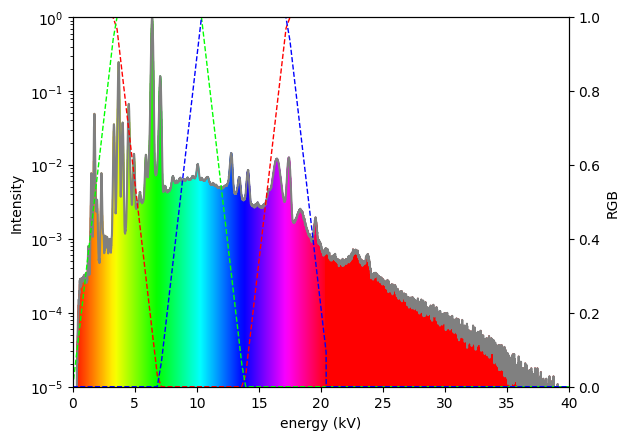

In [18]:
#import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

nview=2044
vymin=-1
vymin=0

venergy=energy
ps=clustaverages[1,1]
#ps=np.log(ps) #/max(clustaverages[1,1])
ps=ps/max(ps)

cred=np.zeros(config.NCHAN)
cgreen=np.zeros(config.NCHAN)
cred=np.zeros(config.NCHAN)

npad=config.NCHAN-nview

print(npad)

print(cred.shape)

hsv=cm.get_cmap('hsv', nview)

cmap=hsv(range(nview))
print('colarray',cmap[0,:3])    #index starts from 1 instead of 0, not sure why

cred=cmap[:,0]
cgreen=cmap[:,1]
cblue=cmap[:,2]

print(cred.shape)

cred=np.pad(cred, (0, npad), 'constant', constant_values=(0, 1))
cgreen=np.pad(cgreen, (0, npad), 'constant', constant_values=(0, 0))
cblue=np.pad(cblue, (0, npad), 'constant', constant_values=(0, 0))

print(cred.shape)


fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=40)
ax1.set_yscale('log')
#ax1.axis(ymin=vymin,ymax=1)
ax1.axis(ymin=0.00001,ymax=1)

ax2 = ax1.twinx() 
ax2.set_ylabel('RGB')
ax2.axis(ymin=0,ymax=1)


ax2.plot(venergy, cred, '#ff0000', linestyle='dashed', linewidth=1)
ax2.plot(venergy, cgreen, '#00ff00', linestyle='dashed', linewidth=1)
ax2.plot(venergy, cblue, '#0000ff', linestyle='dashed', linewidth=1)

ax1.plot(venergy, ps, color="gray")
for i in range(len(ps) - 1):
    ax1.fill_between([energy[i], energy[i+1]], [ps[i], ps[i+1]], y2=vymin, color=(cred[i],cgreen[i],cblue[i]))


#plt.savefig(os.path.join(config.odir, 'hsv_spectrum.png'), dpi=150)
plt.show()





1.8105571025126692


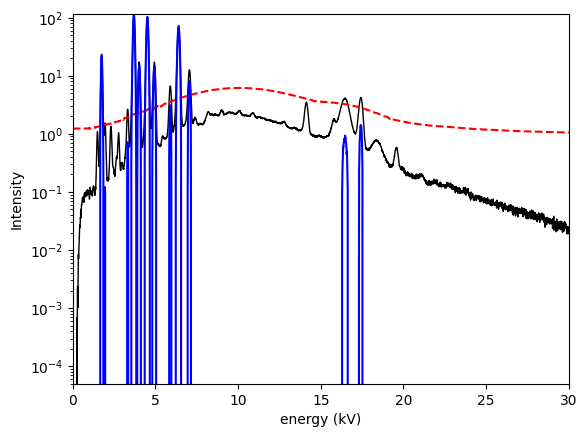

In [30]:
import importlib
importlib.reload(fitting)

import matplotlib.pyplot as plt
import pybaselines.morphological

"""
SNIP TESTING
"""

nview=2044
vymin=-1
vymin=0

venergy=energy
ps=clustaverages[1,1]
#ps=data[20000,:]
#ps=data[5000,:]
#ps=data[100,:]

print(np.average(ps))

#ps=np.log(ps) #/max(clustaverages[1,1])
#ps=ps/max(ps)

ps2, bg=fitting.fitbaseline(ps,True)

fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)
ax1.set_yscale('log')
ax1.axis(ymin=0.00005,ymax=max(ps))


ax1.plot(venergy, ps, color="black", linewidth=1)
ax1.plot(venergy, bg, color="red", linestyle='dashed')
ax1.plot(venergy, ps2, color="blue")



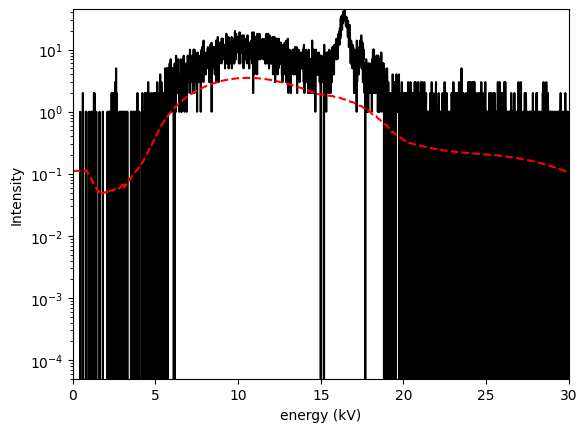

In [36]:
spec=clustaverages[1,3]
spec=data[0,:]
bline=baseline*0.4

fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)
ax1.set_yscale('log')
ax1.axis(ymin=0.00005,ymax=max(spec))

ax1.plot(venergy, spec, color="black")
ax1.plot(venergy, bline, color="red", linestyle='dashed')
#ax1.plot(venergy, spec-bline, color="blue", linestyle='dashed')

rgb maxima2: r 0.3032921022838091 g 0.4538931494570601 b 0.24342022786544373
chmax 0.4538931494570601, 1.0
scaled maxima: r 0.6682015418091293 g 1.0 b 0.5362941215495745


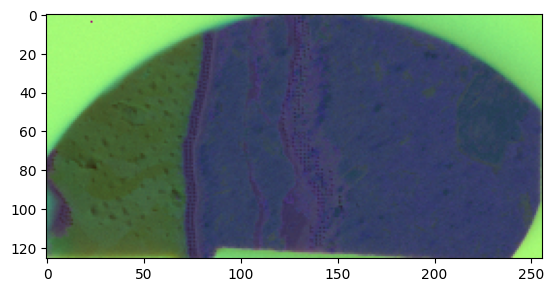

In [10]:
import importlib
importlib.reload(colour)

if config.DOCOLOURS == True:
    rgbarray=colour.clcomplete(rvals, gvals, bvals, totalcounts, mapx, nrows)
    colour.clshow(rgbarray)

In [2]:
#import importlib
#importlib.reload(utils)

utils.varsizes(locals().items())

                          data: 252.0 MiB
                     embedding: 504.1 KiB
                 clustaverages: 320.1 KiB
                         rvals: 252.1 KiB
                         gvals: 252.1 KiB
                         bvals: 252.1 KiB
                   totalcounts: 252.1 KiB
                      rgbarray: 94.6 KiB
                    categories: 63.1 KiB
                         pxlen: 63.1 KiB


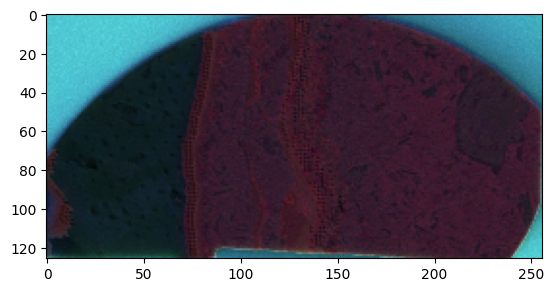

In [3]:
import importlib
importlib.reload(colour)

colour.clshow(rgbarray)




In [4]:
print("DOCLUST", config.DOCLUST)
if True:
    embedding, clusttimes = clustering.reduce(data)
    categories = clustering.dokmeans(embedding, totalpx)

    clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])

    for i in range(len(clustering.reducers)):
        redname=clustering.getredname(i)
        clustaverages[i]=clustering.sumclusters(data, categories[i])
        
        for j in range(config.nclust):
            print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
        
        print(f'saving combined file for {redname}')
        np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
        #plt.plot(energy, clustaverages[i,j,:])
    clustering.clustplt(embedding, categories, mapx, clusttimes)

DOCLUST False
REDUCER 1 of 1: UMAP across 772404 elements
UMAP(min_dist=0.3, n_neighbors=30, verbose=True)
Thu Sep 29 23:04:07 2022 Construct fuzzy simplicial set
Thu Sep 29 23:04:19 2022 Finding Nearest Neighbors
Thu Sep 29 23:04:22 2022 Building RP forest with 49 trees


: 

: 

In [ ]:
importlib.reload(clustering)

if config.DOCOLOURS == True:
    rgbarray=colour.clcomplete(rvals, gvals, bvals, totalcounts)
    colour.clshow(rgbarray)

print("DOCLUST", config.DOCLUST)
if config.DOCLUST:
    embedding, clusttimes = clustering.reduce(data)
    categories = clustering.dokmeans(embedding, totalpx)

    clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])

    for i in range(len(clustering.reducers)):
        redname=clustering.getredname(i)
        clustaverages[i]=clustering.sumclusters(data, categories[i])
        
        for j in range(config.nclust):
            print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
        
        print(f'saving combined file for {redname}')
        np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
        #plt.plot(energy, clustaverages[i,j,:])
    clustering.clustplt(embedding, categories, mapx, clusttimes)

In [ ]:
print(data.shape)

print(data[:,0:2500].shape)

rdata=data[:,0:2500]

#data=rdata

In [ ]:
import importlib
importlib.reload(clustering)

utils.varsizes(locals().items())


print("DOCLUST", config.DOCLUST)

if True:
    embedding, clusttimes = clustering.reduce(data)
    categories = clustering.dokmeans(embedding, totalpx)

    clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])

    for i in range(len(clustering.reducers)):
        redname=clustering.getredname(i)
        clustaverages[i]=clustering.sumclusters(data, categories[i])
        
        for j in range(config.nclust):
            print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
        
        print(f'saving combined file for {redname}')
        np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
        #plt.plot(energy, clustaverages[i,j,:])
    clustering.clustplt(embedding, categories, mapx, clusttimes)

In [ ]:
del embedding
del categories
del clustaverages
gc.collect()

In [ ]:
rdata = np.loadtxt(os.path.join(config.odir, "pxspec_dw.dat"), dtype=np.uint16)

print(data.shape)
print(rdata.shape)

In [ ]:
print(rdata[200,50:100])
print(data[200,50:100])

In [ ]:
utils.varsizes(locals().items())

In [ ]:
import matplotlib.pyplot as plt

workspec=clustaverages[1,4,:]

#plt.xscale("log")

plt.xlim(0.5,25)
plt.yscale("log")
plt.ylim(0.04,1000)
plt.plot(energy,workspec)




In [ ]:
"""
Baseline correction
"""
import pandas as pd
from scipy.signal import gaussian

#pybaselines project looks great
#https://pypi.org/project/pybaselines/

#alternately code from
#https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data

def baseline_correction4(raman_spectra,lam,p,niter=10):
    #according to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    number_of_spectra = raman_spectra.index.size

    #this is the code for the fitting procedure        
    L = len(raman_spectra.columns)
    w = np.ones(raman_spectra.shape[0]*raman_spectra.shape[1])

    D = sparse.block_diag(np.tile(sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2)),number_of_spectra),format='csr')

    raman_spectra_flattened = raman_spectra.values.ravel()

    for jj in range(int(niter)):
        W = sparse.diags(w,format='csr')
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z,w*raman_spectra_flattened,permc_spec='NATURAL')
        w = p * (raman_spectra_flattened > z) + (1-p) * (raman_spectra_flattened < z)
    #end of fitting procedure

    baseline_data = pd.DataFrame(z.reshape(number_of_spectra,-1),index=raman_spectra.index,columns=raman_spectra.columns)
    return baseline_data

In [ ]:
import struct 
import json

"""
https://stackoverflow.com/questions/40059654/python-convert-a-bytes-array-into-json-format
"""

headerstream=stream[2:headerlen+2]

headerstream = headerstream.decode('utf8')
"""
print(header[-100])
print("--------------------------")
print(jsonheader)
print("--------------------------")
#print(jsonheader[1300:1600])
#print("--------------------------")
print(jsonheader[1450:1480])
print(len(jsonheader))
"""

headerdict = json.loads(headerstream)
headerdump = json.dumps(headerdict, indent=4, sort_keys=False)

print(headerdump)
print("KEYS")
print(headerdict.keys())
nmapx=headerdict['File Header']['Xres']
nmapy=headerdict['File Header']['Yres']

print(nmapx,nmapy)



In [ ]:
import json

print(f)


with open(f) as file: # rb = read binary
  
    # returns JSON object as 
    # a dictionary
    jsondata = json.load(file)
    
    # Iterating through the json
    # list
    for i in jsondata['emp_details']:
        print(i)
    
    # Closing file
    #f.close()